# Fashion-MNIST CNN

Custom CNN (≥3 conv layers) on Fashion-MNIST with train/val/test splits, augmentation + regularization, and metrics (acc, precision/recall/F1, confusion matrix).



In [1]:
# Setup

import os
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE



device(type='cuda')

In [2]:
@dataclass
class Config:
    seed: int = 42
    data_root: str = "./data"

    # split
    train_size: int = 50_000
    val_size: int = 10_000

    # training
    batch_size: int = 256
    epochs: int = 15
    lr: float = 3e-3
    weight_decay: float = 1e-2
    label_smoothing: float = 0.0

    # regularization
    dropout_p: float = 0.25

    # augmentation
    use_hflip: bool = True
    rotation_deg: float = 10.0
    random_erasing_p: float = 0.15

    # dataloader
    num_workers: int = min(4, os.cpu_count() or 2)

    # early stopping
    early_stop_patience: int = 4

    # checkpoint
    checkpoint_path: str = "best_fashionmnist_cnn.pt"


CFG = Config()
CFG



Config(seed=42, data_root='./data', train_size=50000, val_size=10000, batch_size=256, epochs=15, lr=0.003, weight_decay=0.01, label_smoothing=0.0, dropout_p=0.25, use_hflip=True, rotation_deg=10.0, random_erasing_p=0.15, num_workers=2, early_stop_patience=4, checkpoint_path='best_fashionmnist_cnn.pt')

In [3]:
# Data

FASHIONMNIST_MEAN = 0.2860
FASHIONMNIST_STD = 0.3530


def build_transforms(cfg: Config):
    train_tfms = [
        transforms.RandomCrop(28, padding=4),
        transforms.RandomRotation(cfg.rotation_deg),
    ]
    if cfg.use_hflip:
        train_tfms.append(transforms.RandomHorizontalFlip(p=0.5))

    train_tfms += [
        transforms.ToTensor(),
        transforms.Normalize((FASHIONMNIST_MEAN,), (FASHIONMNIST_STD,)),
    ]

    if cfg.random_erasing_p and cfg.random_erasing_p > 0:
        train_tfms.append(transforms.RandomErasing(p=cfg.random_erasing_p, value=0.0))

    eval_tfms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((FASHIONMNIST_MEAN,), (FASHIONMNIST_STD,)),
        ]
    )

    return transforms.Compose(train_tfms), eval_tfms


def make_splits(cfg: Config):
    set_seed(cfg.seed)

    train_transform, eval_transform = build_transforms(cfg)

    ds_train_full = datasets.FashionMNIST(
        root=cfg.data_root, train=True, download=True, transform=train_transform
    )
    ds_eval_full = datasets.FashionMNIST(
        root=cfg.data_root, train=True, download=True, transform=eval_transform
    )

    assert len(ds_train_full) == len(ds_eval_full) == cfg.train_size + cfg.val_size

    g = torch.Generator().manual_seed(cfg.seed)
    indices = torch.randperm(len(ds_train_full), generator=g).tolist()
    train_indices = indices[: cfg.train_size]
    val_indices = indices[cfg.train_size : cfg.train_size + cfg.val_size]

    train_ds = Subset(ds_train_full, train_indices)
    val_ds = Subset(ds_eval_full, val_indices)

    test_ds = datasets.FashionMNIST(
        root=cfg.data_root, train=False, download=True, transform=eval_transform
    )

    class_names = datasets.FashionMNIST.classes

    return train_ds, val_ds, test_ds, class_names


def make_loaders(cfg: Config):
    train_ds, val_ds, test_ds, class_names = make_splits(cfg)

    pin = DEVICE.type == "cuda"

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=pin,
        persistent_workers=cfg.num_workers > 0,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=pin,
        persistent_workers=cfg.num_workers > 0,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=pin,
        persistent_workers=cfg.num_workers > 0,
    )

    return train_loader, val_loader, test_loader, class_names


train_loader, val_loader, test_loader, CLASS_NAMES = make_loaders(CFG)
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset), CLASS_NAMES



100%|██████████| 26.4M/26.4M [00:03<00:00, 8.18MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.9MB/s]


(50000,
 10000,
 10000,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

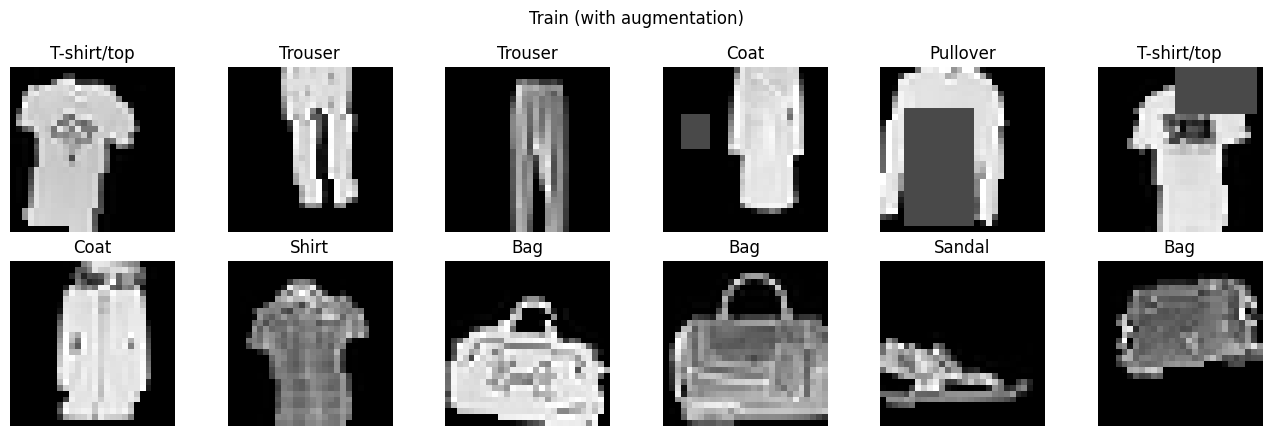

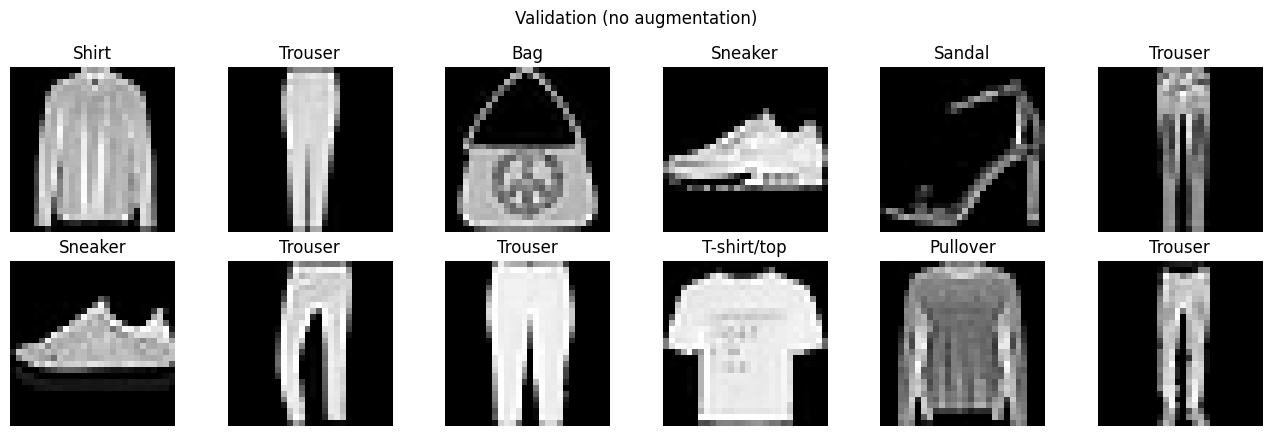

In [4]:
# Viz

def denorm(x: torch.Tensor):
    return x * FASHIONMNIST_STD + FASHIONMNIST_MEAN


def show_batch(loader: DataLoader, title: str, n: int = 12):
    x, y = next(iter(loader))
    x = denorm(x[:n]).clamp(0, 1)
    y = y[:n].numpy()

    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(x[i, 0].numpy(), cmap="gray")
        plt.title(CLASS_NAMES[y[i]])
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


show_batch(train_loader, "Train (with augmentation)")
show_batch(val_loader, "Validation (no augmentation)")



## Model

CNN (5 conv layers) + BN + dropout.



In [5]:
class FashionMNISTCNN(nn.Module):
    def __init__(self, dropout_p: float = 0.25):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout_p * 0.5),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout_p),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.head(x)
        return x


model = FashionMNISTCNN(dropout_p=CFG.dropout_p).to(DEVICE)
print(model)

# quick shape check
x_dummy = torch.randn(4, 1, 28, 28).to(DEVICE)
out = model(x_dummy)
out.shape



FashionMNISTCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.125, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): M

torch.Size([4, 10])

## Train



In [ ]:
from time import time


def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    scaler: torch.cuda.amp.GradScaler | None,
    scheduler: torch.optim.lr_scheduler._LRScheduler | None = None,
) -> Dict[str, float]:
    model.train()
    losses: List[float] = []
    accs: List[float] = []

    use_amp = scaler is not None

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # automatic mixed precision, uses mixed precision to speed up training
        # as amp uses float16, values can overflow or underflow so gradscaler prevents this
        if use_amp:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # forward pass
            logits = model(x)
            # calculate loss
            loss = criterion(logits, y)
            # backprop
            loss.backward()
            # update weights and shit
            optimizer.step()
        
        # lr scheduler
        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits.detach(), y))

    return {"loss": float(np.mean(losses)), "acc": float(np.mean(accs))}


def eval_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
) -> Dict[str, float]:
    model.eval()
    losses: List[float] = []
    accs: List[float] = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            logits = model(x)
            loss = criterion(logits, y)

            losses.append(loss.item())
            accs.append(accuracy_from_logits(logits, y))

    return {"loss": float(np.mean(losses)), "acc": float(np.mean(accs))}



In [7]:
def fit(cfg: Config, model: nn.Module):
    set_seed(cfg.seed)

    train_loader, val_loader, _, _ = make_loaders(cfg)

    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay
    )

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=cfg.lr,
        epochs=cfg.epochs,
        steps_per_epoch=len(train_loader),
    )

    use_amp = DEVICE.type == "cuda"
    scaler_obj = torch.cuda.amp.GradScaler(enabled=use_amp)
    scaler = scaler_obj if use_amp else None

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "lr": [],
    }

    best_val_loss = float("inf")
    best_epoch = -1
    patience_left = cfg.early_stop_patience

    t0 = time()

    for epoch in range(1, cfg.epochs + 1):
        train_stats = train_one_epoch(
            model, train_loader, optimizer, criterion, scaler, scheduler
        )
        val_stats = eval_one_epoch(model, val_loader, criterion)

        history["train_loss"].append(train_stats["loss"])
        history["train_acc"].append(train_stats["acc"])
        history["val_loss"].append(val_stats["loss"])
        history["val_acc"].append(val_stats["acc"])
        history["lr"].append(optimizer.param_groups[0]["lr"])

        improved = val_stats["loss"] < best_val_loss - 1e-6
        if improved:
            best_val_loss = val_stats["loss"]
            best_epoch = epoch
            patience_left = cfg.early_stop_patience
            torch.save(model.state_dict(), cfg.checkpoint_path)
        else:
            patience_left -= 1

        print(
            f"Epoch {epoch:02d}/{cfg.epochs} | "
            f"train loss {train_stats['loss']:.4f} acc {train_stats['acc']:.4f} | "
            f"val loss {val_stats['loss']:.4f} acc {val_stats['acc']:.4f} | "
            f"lr {optimizer.param_groups[0]['lr']:.2e} | "
            f"best val loss {best_val_loss:.4f} (epoch {best_epoch})"
        )

        if patience_left <= 0:
            print(f"Early stopping triggered at epoch {epoch}. Best epoch: {best_epoch}.")
            break

    print(f"Training time: {time() - t0:.1f}s")

    model.load_state_dict(torch.load(cfg.checkpoint_path, map_location=DEVICE))
    return history


model = FashionMNISTCNN(dropout_p=CFG.dropout_p).to(DEVICE)
history = fit(CFG, model)



/tmp/ipython-input-2929654197.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_obj = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipython-input-959835210.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01/15 | train loss 1.6891 acc 0.4043 | val loss 1.0529 acc 0.6892 | lr 4.58e-04 | best val loss 1.0529 (epoch 1)
Epoch 02/15 | train loss 0.9793 acc 0.6596 | val loss 0.7492 acc 0.7164 | lr 1.31e-03 | best val loss 0.7492 (epoch 2)
Epoch 03/15 | train loss 0.7458 acc 0.7296 | val loss 0.5234 acc 0.7996 | lr 2.28e-03 | best val loss 0.5234 (epoch 3)
Epoch 04/15 | train loss 0.6494 acc 0.7588 | val loss 0.4760 acc 0.8144 | lr 2.91e-03 | best val loss 0.4760 (epoch 4)
Epoch 05/15 | train loss 0.5843 acc 0.7847 | val loss 0.4124 acc 0.8477 | lr 2.98e-03 | best val loss 0.4124 (epoch 5)
Epoch 06/15 | train loss 0.5319 acc 0.8037 | val loss 0.3917 acc 0.8562 | lr 2.85e-03 | best val loss 0.3917 (epoch 6)
Epoch 07/15 | train loss 0.4931 acc 0.8208 | val loss 0.3658 acc 0.8674 | lr 2.60e-03 | best val loss 0.3658 (epoch 7)
Epoch 08/15 | train loss 0.4638 acc 0.8319 | val loss 0.3212 acc 0.8836 | lr 2.25e-03 | best val loss 0.3212 (epoch 8)
Epoch 09/15 | train loss 0.4417 acc 0.8386 | val

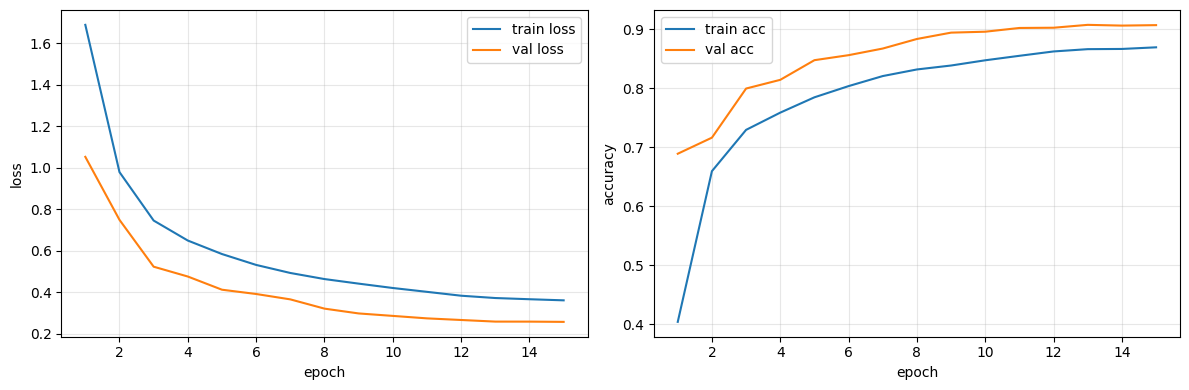

In [8]:
# Curves

def plot_history(history: Dict[str, List[float]]):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_history(history)



## Eval



In [9]:
@torch.no_grad()
def predict(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    all_preds: List[int] = []
    all_targets: List[int] = []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()

        all_preds.extend(preds)
        all_targets.extend(y.numpy().tolist())

    return np.array(all_targets), np.array(all_preds)


test_loader = make_loaders(CFG)[2]

y_true, y_pred = predict(model, test_loader)

test_acc = accuracy_score(y_true, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print(f"Test accuracy: {test_acc:.4f}")
print(
    f"Macro P/R/F1: {prec_macro:.4f} / {rec_macro:.4f} / {f1_macro:.4f} | "
    f"Weighted P/R/F1: {prec_weight:.4f} / {rec_weight:.4f} / {f1_weight:.4f}"
)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))



Test accuracy: 0.9007
Macro P/R/F1: 0.9000 / 0.9007 / 0.8995 | Weighted P/R/F1: 0.9000 / 0.9007 / 0.8995

Classification report:

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.88      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.86      0.89      0.88      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.82      0.88      0.85      1000
      Sandal       0.99      0.96      0.97      1000
       Shirt       0.75      0.63      0.69      1000
     Sneaker       0.92      0.97      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



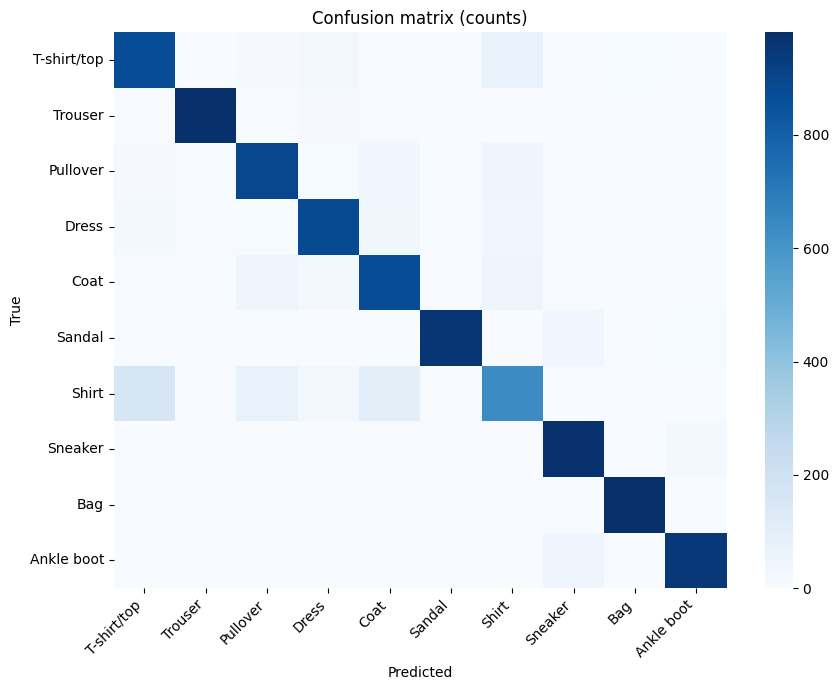

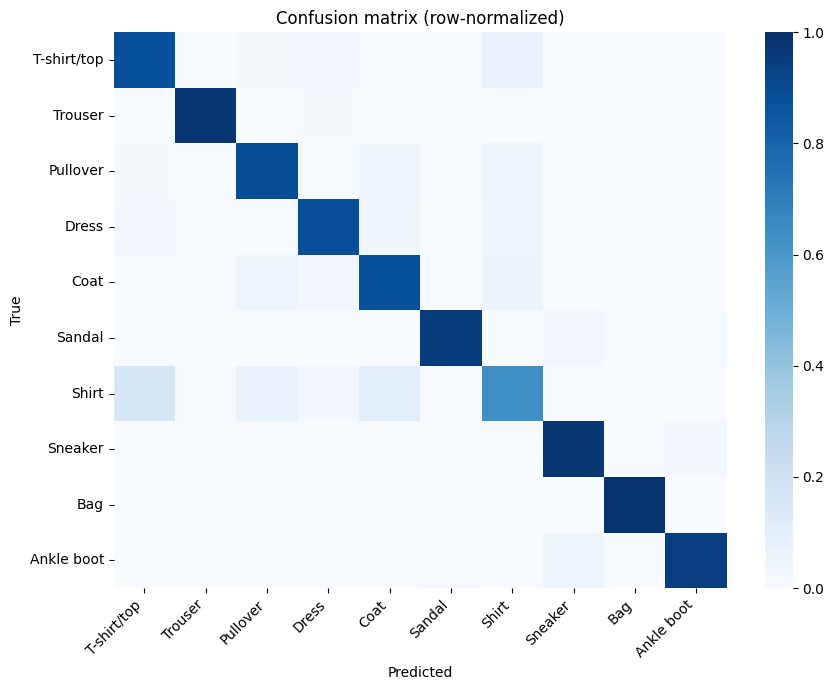

In [10]:
# CM

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_NAMES))))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion matrix (counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm,
    annot=False,
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    vmin=0,
    vmax=1,
)
plt.title("Confusion matrix (row-normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



Collected 24 misclassified samples


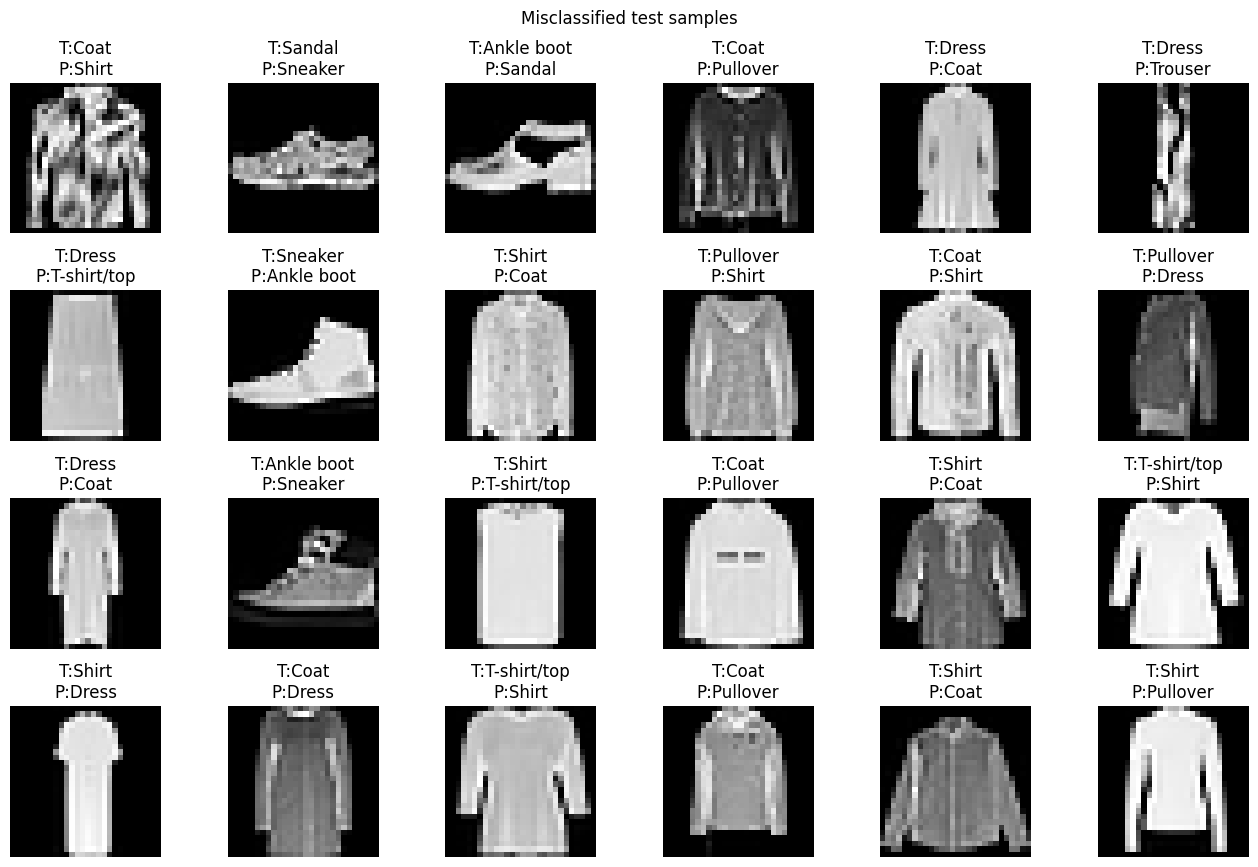

In [11]:
# Errors

@torch.no_grad()
def collect_misclassifications(
    model: nn.Module, loader: DataLoader, max_items: int = 24
):
    model.eval()
    items = []

    for x, y in loader:
        x_dev = x.to(DEVICE, non_blocking=True)
        logits = model(x_dev)
        preds = torch.argmax(logits, dim=1).cpu()

        mism = preds != y
        if mism.any():
            for i in torch.where(mism)[0].tolist():
                items.append((x[i], int(y[i]), int(preds[i])))
                if len(items) >= max_items:
                    return items

    return items


mis_items = collect_misclassifications(model, test_loader, max_items=24)
print(f"Collected {len(mis_items)} misclassified samples")

cols = 6
rows = int(np.ceil(len(mis_items) / cols))
plt.figure(figsize=(cols * 2.2, rows * 2.2))

for i, (x, y_t, y_p) in enumerate(mis_items):
    img = denorm(x.unsqueeze(0)).squeeze(0).clamp(0, 1)[0].numpy()

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{CLASS_NAMES[y_t]}\nP:{CLASS_NAMES[y_p]}")
    plt.axis("off")

plt.suptitle("Misclassified test samples")
plt.tight_layout()
plt.show()



## Summary

- checkpoint: `best_fashionmnist_cnn.pt`
- metrics: printed above
- CM: heatmaps above

Notes: aug (crop/rot/flip + erasing), reg (dropout + AdamW wd).

